In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.models import Sequential
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import subprocess
from tensorflow.keras import layers

from pathlib import Path
from collections import Counter

In [2]:
data_dir = Path("input/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# image chứa đường dẫn của image
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 128
img_height = 32


downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  100
Number of labels found:  100
Number of unique characters:  10
Characters present:  {'8', '0', '3', '1', '4', '7', '6', '9', '2', '5'}


In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

print("TRAIN IMAGES: ", train_images.shape)
print("TEST IMAGES: ", test_images.shape)

TRAIN IMAGES:  (60000, 28, 28, 1)
TEST IMAGES:  (10000, 28, 28, 1)


In [4]:
num_classes = 10
img_height = 28
img_width = 28

model = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='sigmoid')
])

In [5]:
def preprocess(img, imgSize ):
    ''' resize, transpose and standardization grayscale images '''
    # create target image and copy sample image into it
    widthTarget, heightTarget = imgSize 
    height, width = img.shape 
    factor_x = width / widthTarget
    factor_y = height / heightTarget

    factor = max(factor_x, factor_y)
    # scale according to factor
    newSize = (min(widthTarget, int(width / factor)), min(heightTarget, int(height / factor)))

    img = cv2.resize(img, newSize)
    target = np.ones(shape=(heightTarget, widthTarget), dtype='uint8') * 255
    target[0:newSize[1], 0:newSize[0]] = img
    # transpose
    img = cv2.transpose(target)
    # standardization
    mean, stddev = cv2.meanStdDev(img)
    mean = mean[0][0]
    stddev = stddev[0][0]
    img = img - mean
    img = img // stddev if stddev > 0 else img
    return img

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
train_size = int(0.8 * len(labels))
valid_size= int(len(labels) - train_size)
# 80% data is for training. The rest of them is for validation

print ('\ntrain_size',train_size,'  valid_size',valid_size)


train_size 80   valid_size 20



 train_x.shape (80, 128, 32, 1)

 valid_x.shape (20, 128, 32, 1)

 Example of label_valid 8393170


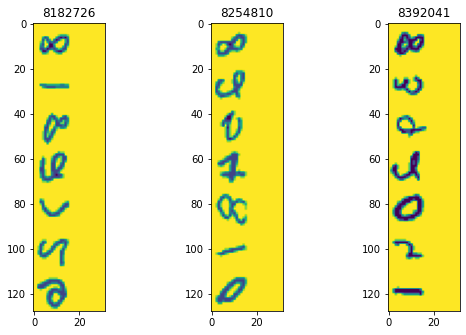

In [8]:
train_x = []
valid_x = []
i=0
for image in images:
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image, (128,32)) 
    image = image/255.
    if i < train_size:
        train_x.append(image)
    else:
        valid_x.append(image)
    i = i+1

train_x = np.array(train_x).reshape(-1, 128, 32, 1)
valid_x = np.array(valid_x).reshape(-1, 128, 32, 1)

print ('\n train_x.shape',train_x.shape)
print ('\n valid_x.shape',valid_x.shape)

label_train = labels[0:train_size]
label_valid = labels[train_size:len(labels)]
# They usually slit images into 2 folders, but I just have 1 so I have to label it again.

#print ('\n label_train',label_train)
print('\n Example of label_valid',label_valid[3])

plt.figure(num='multi digit',figsize=(9,18))
for i in range(3):
    plt.subplot(3,3,i+1) 
    plt.title(label_valid[i])
    plt.imshow(np.squeeze(valid_x[i,:,:,]))
plt.show()


In [9]:
alphabets = u"0123456789' "
max_str_len = 10 # max length of input labels
# My project have 7 digits per image, but as long as the max_str_len > the number of digit per image, 
#it's just fine
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 32 # max length of predicted labels
# I find out that if the num_of_timestamps ... I forgot it... 

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

name = '39816931'
print(name, '\n',label_to_num(name))

39816931 
 [3 9 8 1 6 9 3 1]


In [10]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(label_train[i])
    train_y[i, 0:len(label_train[i])]= label_to_num(label_train[i])  
    

valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(label_valid[i])
    valid_y[i, 0:len(label_valid[i])]= label_to_num(label_valid[i])   

print('\n True label_train  : ',label_train[10] , '\ntrain_y : ',train_y[10],
      '\ntrain_label_len : ',train_label_len[10], '\ntrain_input_len : ', train_input_len[10])

print('\n True label_valid : ',label_valid[10] , '\ntrain_y : ',valid_y[10],
      '\ntrain_label_len : ',valid_label_len[10], '\ntrain_input_len : ', valid_input_len[10])



 True label_train  :  1453681 
train_y :  [ 1.  4.  5.  3.  6.  8.  1. -1. -1. -1.] 
train_label_len :  [7.] 
train_input_len :  [30.]

 True label_valid :  9093718 
train_y :  [ 9.  0.  9.  3.  7.  1.  8. -1. -1. -1.] 
train_label_len :  [7.] 
train_input_len :  [30.]


In [11]:
def build_model(img_width = 128,img_height = 32, max_str_len = 10):
    # Inputs to the model

    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    y_pred = layers.Dense(10 + 1, activation="softmax", name="dense2")(x) # y pred
    model = keras.models.Model(inputs=input_img, outputs=y_pred, name="functional_1")

    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        # the 2 is critical here since the first couple outputs of the RNN
        # tend to be garbage
        y_pred = y_pred[:, 2:, :]
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

    labels = layers.Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

    ctc_loss = keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    model_final = keras.models.Model(inputs=[input_img, labels, input_length, label_length], outputs=ctc_loss, name = "ocr_model_v1")
    
    return model, model_final

model, model_final = build_model()
model.summary()
model_final.summary()

Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 32, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 16, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 8, 64)         0         
                                                                 
 reshape (Reshape)           (None, 32, 512)           0         
                                                                 
 dense1 (Dense)              (None, 32, 64)           

In [12]:
model.summary()

Model: "functional_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 128, 32, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 64, 16, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 64, 16, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 32, 8, 64)         0         
                                                                 
 reshape (Reshape)           (None, 32, 512)           0         
                                                                 
 dense1 (Dense)              (None, 32, 64)           

In [5]:
epochs = 10
history = model.fit(
  train_images, 
  train_labels,
  epochs = epochs
)

Epoch 1/10


C:\Users\Zero\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 113s 59ms/step - loss: 0.1434 - accuracy: 0.9553
Epoch 2/10
1875/1875 [==============================] - 110s 58ms/step - loss: 0.0456 - accuracy: 0.9858
Epoch 3/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.0332 - accuracy: 0.9898
Epoch 4/10
1875/1875 [==============================] - 110s 59ms/step - loss: 0.0276 - accuracy: 0.9917
Epoch 5/10
1875/1875 [==============================] - 110s 59ms/step - loss: 0.0219 - accuracy: 0.9926
Epoch 6/10
1875/1875 [==============================] - 110s 59ms/step - loss: 0.0177 - accuracy: 0.9939
Epoch 7/10
1875/1875 [==============================] - 110s 59ms/step - loss: 0.0152 - accuracy: 0.9952
Epoch 8/10
1875/1875 [==============================] - 113s 60ms/step - loss: 0.0146 - accuracy: 0.9953
Epoch 9/10
1875/1875 [==============================] - 111s 59ms/step - loss: 0.0114 - accuracy: 0.9961
Epoch 10/10
1875/1875 [==============================] - 110s 59ms

Text(0.5, 1.0, 'Training Accuracy and Loss')

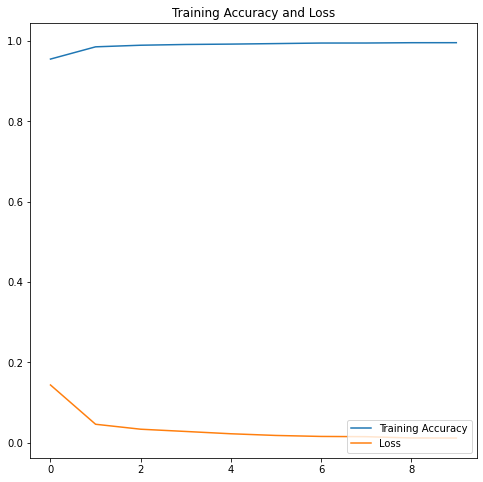

In [6]:
acc = history.history['accuracy']
loss=history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, loss, label='Loss')
plt.legend(loc='lower right')
plt.title('Training Accuracy and Loss')


Prediction of model: [1.0000000e+00 1.8580040e-06 1.4582408e-02 1.0294661e-04 3.6333557e-04
 8.1359969e-05 9.1184890e-01 3.5983616e-09 5.3991590e-02 5.0758797e-04]


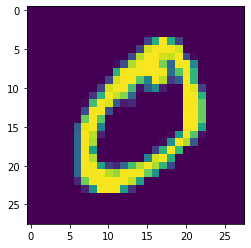

In [10]:
image = (train_images[1]).reshape(1,28,28,1)
model_pred = model.predict(image, verbose=0)

plt.imshow(image.reshape(28,28))
print('Prediction of model: {}'.format(model_pred[0]))

In [8]:
from tensorflow.keras.models import Sequential

Prediction of model: [2.1972914e-08 3.8382336e-03 3.5094619e-03 7.9995814e-08 1.0000000e+00
 1.6281320e-03 1.7913498e-08 5.1622294e-02 7.1609218e-04 4.4282025e-01]


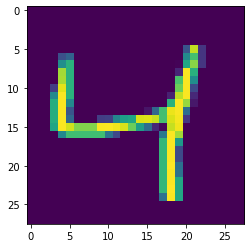

In [12]:
image = (train_images[2]).reshape(1,28,28,1)
model_pred = model.predict(image, verbose=0)
plt.imshow(image.reshape(28,28))
print('Prediction of model: {}'.format(model_pred[0]))

Test images array shape: (4, 28, 28)
Predicted digit: [2.36581309e-05 5.16792893e-01 1.00000000e+00 1.13332244e-04
 5.90864875e-05 6.95250732e-11 1.00029763e-04 5.18177729e-03
 1.17331547e-06 4.83876611e-05]
Predicted digit: [4.8999937e-04 9.9999344e-01 3.8041871e-02 6.4928900e-05 4.7696759e-03
 1.3537261e-01 4.2178354e-01 3.0959600e-01 1.4470102e-01 8.5481576e-04]
Predicted digit: [1.0000000e+00 4.1175241e-05 1.1186241e-03 1.9134081e-04 1.4249665e-04
 1.5084441e-02 9.8683625e-01 1.4353758e-06 2.2572221e-02 2.9408548e-03]
Predicted digit: [8.3206563e-05 1.8423198e-04 3.7122404e-04 3.0264686e-04 9.9999881e-01
 2.1331140e-03 1.7971997e-04 3.0478234e-03 5.6018453e-02 9.3284971e-01]


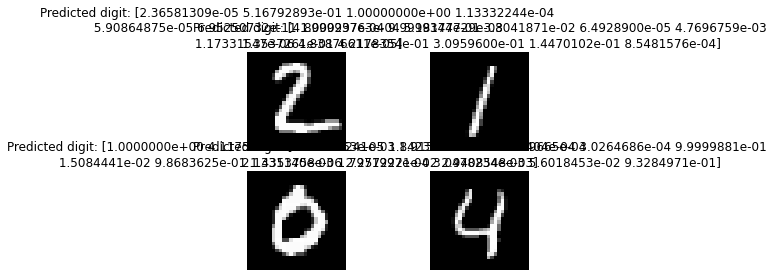

In [13]:

images = test_images[1:5]
images = images.reshape(images.shape[0], 28, 28)
print ("Test images array shape: {}".format(images.shape))


for i, test_image in enumerate(images, start=1):

    org_image = test_image
    test_image = test_image.reshape(1,28,28,1)
    prediction = model.predict(test_image, verbose=0)

    print ("Predicted digit: {}".format(prediction[0]))
    plt.subplot(220+i)
    plt.axis('off')
    plt.title("Predicted digit: {}".format(prediction[0]))
    plt.imshow(org_image, cmap=plt.get_cmap('gray'))

plt.show()


In [14]:
model.save("tf-cnn-model.h5")

In [15]:
loaded_model = models.load_model("tf-cnn-model.h5")

Prediction of model: [2.1972914e-08 3.8382336e-03 3.5094619e-03 7.9995814e-08 1.0000000e+00
 1.6281320e-03 1.7913498e-08 5.1622294e-02 7.1609218e-04 4.4282025e-01]


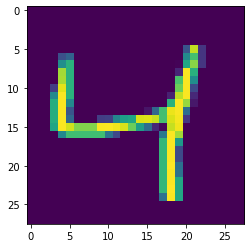

In [16]:
image = (train_images[2]).reshape(1,28,28,1)
model_pred = loaded_model.predict(image, verbose=0)
plt.imshow(image.reshape(28,28))
print('Prediction of model: {}'.format(model_pred[0]))